<h2 style="text-align: center;"><b>K Nearest Neighbors (KNN)</b></h2>

Метод ближайших соседей (k Nearest Neighbors, или kNN) — очень популярный метод классификации, также иногда используемый в задачах регрессии. Это один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей; какие преобладают --- таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

<img src='https://hsto.org/web/68d/a45/6f0/68da456f00f8434e87628dbe7e3f54a7.png' width=600>


Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
all_data = pd.read_csv('data/forest_dataset.csv')
all_data

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3088,217,21,295,53,2912,194,254,190,1590,...,0,0,0,0,0,0,0,0,0,2
9996,2569,129,10,0,0,1273,237,234,127,5094,...,0,0,0,0,0,0,0,0,0,2
9997,2693,21,11,30,6,2316,212,216,139,2110,...,0,0,0,0,0,0,0,0,0,2
9998,2536,42,11,277,19,323,222,216,128,2844,...,0,0,0,0,0,0,0,0,0,2


In [3]:
all_data.shape

(10000, 55)

Выделим значения метки класса в переменную `labels`, признаковые описания - в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в numpy-формат с помощью метода `.values`.

In [4]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

### Пара слов о sklearn

**[sklearn](https://scikit-learn.org/stable/index.html)** -- удобная библиотека для знакомства с машинным обучением. В ней реализованны большинство стандартных алгоритмов для построения моделей и работ с выборками. У неё есть подробная документация на английском, с которой вам придётся поработать.

`sklearn` предпологает, что ваши выборки имеют вид пар $(X, y)$, где $X$ -- матрица признаков, $y$ -- вектор истинных значений целевой переменной, или просто $X$, если целевые переменные неизвестны.

Разделим выборку на обучающую и тестовую с помощью метода `train_test_split`.

In [5]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

Основные объекты `sklearn` -- так называемые `estimators`, что можно перевести как *оценщики*, но не стоит, так как по сути это *модели*. Они делятся на **классификаторы** и **регрессоры**.

В качестве примера модели можно привести классификаторы
[метод ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) и 
[логистическую регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Что такое логистическая регрессия и как она работает сейчас не важно.

У всех моделей в `sklearn` обязательно должно быть хотя бы 2 метода -- `fit` и `predict`.

Метод `fit(X, y)` отвечает за обучение модели и принимает на вход обучающую выборку в виде *матрицы признаков* $X$ и *вектора ответов* $y$.

У обученной после `fit` модели теперь можно вызывать метод `predict(X)`, который вернёт предсказания этой модели на всех объектах из матрицы $X$ в виде вектора.

Вызывать `fit` у одной и той же модели можно несколько раз, каждый раз она будет обучаться заново на переданном наборе данных.

Ещё у моделей есть *гиперпараметры*, которые обычно задаются при создании модели.

У моделей есть много гиперпараметров, которые можно изменять, и от этих гиперпараметров существенно зависит качество модели, хотелось бы найти наилучшие в этом смысле параметры. Самый простой способ это сделать -- просто перебрать все возможные варианты в разумных пределах.

Сделать это можно с помощью класса [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), который осуществляет поиск (search) по сетке (grid) и вычисляет качество модели с помощью кросс-валидации (CV).

У логистической регрессии, например, можно поменять параметры `C` и `penalty`.

### Обучение модели

Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

* число соседей `n_neighbors`
* метрика расстояния между объектами `metric`
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос") `weights`

**Задание**: Обучите на датасете KNeighborsClassifier из sklearn.

In [6]:
clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

In [7]:
accuracy_score(test_labels, y_pred)

0.7365

Качество = 0.7365

__Подберём параметры нашей модели__

**Задание**:
* Переберите по сетке от 1 до 10 параметр числа соседей

* Также вы попробуйте использоввать различные метрики: [`manhattan`, `euclidean`]

* Попробуйте использовать различные стратегии вычисления весов: [`uniform`, `distance`]

In [8]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': [i for i in range(1, 11)],
          'weights': ['uniform', 'distance'],
          'metric': ['manhattan', 'euclidean']}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)

clf_grid.fit(train_feature_matrix, train_labels)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Выведем лучшие параметры

In [9]:
print(clf_grid.best_params_)

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


Лучше использовать метрику `manhattan`, количество `n_neighbors` = 4 и тип `weights` - `distance`

**Задание**: используя найденное оптимальное число соседей, вычислите вероятности принадлежности к классам для тестовой выборки.

In [10]:
optimal_clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
pred_prob = clf.predict_proba(test_feature_matrix)

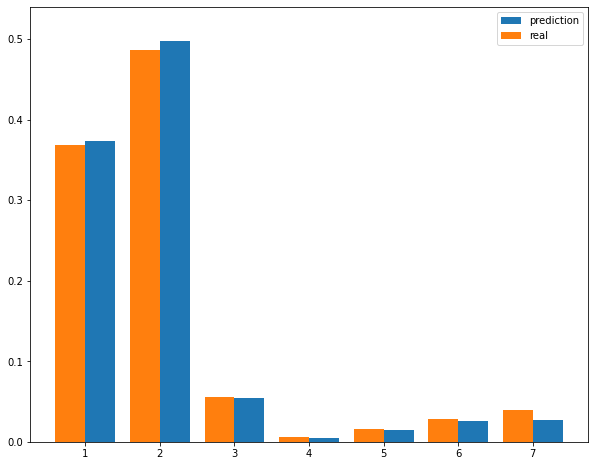

In [11]:
unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

**Задание**: какая прогнозируемая вероятность pred_freq класса под номером 3?

In [12]:
pred_freq[2]

0.05430000000000008